# 📈 Week 14 Trading Strategy: LSTM & GRU for Sequences

---

## 🎯 Strategy Overview

**Building on Weeks 1-13 + Adding Week 14 Concepts:**
- All previous ML methods (regression, classification, trees, MLP)
- **NEW:** LSTM for sequence prediction
- **NEW:** GRU for faster inference
- **NEW:** Sequence-to-sequence modeling
- **NEW:** Attention-weighted predictions

**Strategy Logic:**
1. Create sliding window sequences from price data
2. Train LSTM/GRU models for next-period prediction
3. Compare with baseline models
4. Generate trading signals from predictions

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 2
SEQUENCE_LENGTH = 30
PREDICTION_HORIZON = 5

print("=" * 60)
print("📊 WEEK 14 TRADING STRATEGY: LSTM & GRU SEQUENCES")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Sequence length: {SEQUENCE_LENGTH} days")
print(f"📅 Prediction horizon: {PREDICTION_HORIZON} days")

📊 WEEK 14 TRADING STRATEGY: LSTM & GRU SEQUENCES

🎯 Analyzing: ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
📅 Sequence length: 30 days
📅 Prediction horizon: 5 days


In [2]:
# ============================================================
# IMPORTS & DATA
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
volumes = data['Volume'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")
print(f"   PyTorch version: {torch.__version__}")


📥 Downloading market data...
✅ Loaded 504 trading days
   PyTorch version: 2.9.1


---

## 📊 Section 1: Sequence Preparation

**Creating sliding window sequences:**
- Input: Past N days of features
- Output: Next-period return direction

In [3]:
# ============================================================
# SEQUENCE PREPARATION
# ============================================================

def create_features(prices, returns, volumes, ticker, seq_len=SEQUENCE_LENGTH):
    """Create feature sequences for LSTM/GRU."""
    df = pd.DataFrame(index=prices.index)
    
    # Price-based features
    df['close'] = prices[ticker]
    df['returns'] = returns[ticker]
    df['log_returns'] = np.log(prices[ticker] / prices[ticker].shift(1))
    
    # Volatility
    df['vol_5'] = returns[ticker].rolling(5).std()
    df['vol_20'] = returns[ticker].rolling(20).std()
    
    # Momentum
    df['mom_5'] = prices[ticker].pct_change(5)
    df['mom_20'] = prices[ticker].pct_change(20)
    
    # RSI
    delta = prices[ticker].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = 100 - (100 / (1 + gain / loss))
    
    # Volume ratio
    if ticker in volumes.columns:
        df['vol_ratio'] = volumes[ticker] / volumes[ticker].rolling(20).mean()
    
    return df.dropna()

def create_sequences(features, target, seq_len=SEQUENCE_LENGTH, horizon=PREDICTION_HORIZON):
    """Create sliding window sequences."""
    X, y = [], []
    
    for i in range(len(features) - seq_len - horizon + 1):
        X.append(features[i:i+seq_len])
        # Target: average return over horizon (1 if positive, 0 if negative)
        future_ret = target[i+seq_len:i+seq_len+horizon].mean()
        y.append(1 if future_ret > 0 else 0)
    
    return np.array(X), np.array(y)

# Prepare data for all tickers
all_data = {}
for ticker in TICKERS:
    features = create_features(prices, returns, volumes, ticker)
    
    # Select features for sequence
    feature_cols = ['returns', 'vol_5', 'vol_20', 'mom_5', 'mom_20', 'rsi']
    if 'vol_ratio' in features.columns:
        feature_cols.append('vol_ratio')
    
    # Scale features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features[feature_cols])
    
    # Create sequences
    X, y = create_sequences(scaled_features, features['returns'].values)
    
    if len(X) > 100:
        all_data[ticker] = {
            'X': X, 'y': y,
            'scaler': scaler,
            'feature_cols': feature_cols,
            'features': features
        }
        print(f"{ticker}: {len(X)} sequences, {X.shape[2]} features")

print(f"\n✅ Created sequences for {len(all_data)} tickers")

AAPL: 450 sequences, 7 features
GOOGL: 450 sequences, 7 features
MSFT: 450 sequences, 7 features
GS: 450 sequences, 7 features
JPM: 450 sequences, 7 features

✅ Created sequences for 5 tickers


---

## 📊 Section 2: LSTM & GRU Models

**Model Architectures:**
- LSTM: 2 layers, 64 hidden units, dropout
- GRU: 2 layers, 64 hidden units, dropout
- Output: Binary classification (up/down)

In [4]:
# ============================================================
# MODEL DEFINITIONS
# ============================================================

class LSTMClassifier(nn.Module):
    """LSTM for trading signal classification."""
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Last time step
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out

class GRUClassifier(nn.Module):
    """GRU for trading signal classification."""
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]  # Last time step
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out

print("✅ LSTM and GRU classifier models defined")

✅ LSTM and GRU classifier models defined


In [5]:
# ============================================================
# TRAINING FUNCTION
# ============================================================

def train_sequence_model(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.001):
    """Train sequence model with early stopping."""
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience = 15
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        output = model(X_train).squeeze()
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_output = model(X_val).squeeze()
            val_loss = criterion(val_output, y_val)
            val_losses.append(val_loss.item())
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

print("✅ Training function defined")

✅ Training function defined


In [6]:
# ============================================================
# TRAIN MODELS FOR ALL TICKERS
# ============================================================

results = {}

print("📊 TRAINING SEQUENCE MODELS")
print("=" * 85)
print(f"\n{'Ticker':<10} {'LSTM Acc':>12} {'GRU Acc':>12} {'LSTM Time':>12} {'GRU Time':>12}")
print("-" * 85)

import time

for ticker in TICKERS:
    if ticker not in all_data:
        continue
    
    X = all_data[ticker]['X']
    y = all_data[ticker]['y']
    
    # Split data
    train_end = int(len(X) * 0.6)
    val_end = int(len(X) * 0.8)
    
    X_train = torch.FloatTensor(X[:train_end])
    y_train = torch.FloatTensor(y[:train_end])
    X_val = torch.FloatTensor(X[train_end:val_end])
    y_val = torch.FloatTensor(y[train_end:val_end])
    X_test = torch.FloatTensor(X[val_end:])
    y_test = torch.FloatTensor(y[val_end:])
    
    input_size = X.shape[2]
    
    # Train LSTM
    torch.manual_seed(42)
    lstm = LSTMClassifier(input_size)
    start = time.time()
    lstm, lstm_train_loss, lstm_val_loss = train_sequence_model(lstm, X_train, y_train, X_val, y_val)
    lstm_time = time.time() - start
    
    # Train GRU
    torch.manual_seed(42)
    gru = GRUClassifier(input_size)
    start = time.time()
    gru, gru_train_loss, gru_val_loss = train_sequence_model(gru, X_train, y_train, X_val, y_val)
    gru_time = time.time() - start
    
    # Evaluate
    lstm.eval()
    gru.eval()
    with torch.no_grad():
        lstm_pred = (lstm(X_test).squeeze() > 0.5).float()
        gru_pred = (gru(X_test).squeeze() > 0.5).float()
        lstm_acc = (lstm_pred == y_test).float().mean().item()
        gru_acc = (gru_pred == y_test).float().mean().item()
    
    results[ticker] = {
        'lstm': lstm, 'gru': gru,
        'lstm_acc': lstm_acc, 'gru_acc': gru_acc,
        'lstm_time': lstm_time, 'gru_time': gru_time,
        'lstm_train_loss': lstm_train_loss, 'lstm_val_loss': lstm_val_loss,
        'gru_train_loss': gru_train_loss, 'gru_val_loss': gru_val_loss,
        'X_test': X_test, 'y_test': y_test
    }
    
    print(f"{ticker:<10} {lstm_acc:>11.2%} {gru_acc:>11.2%} {lstm_time:>11.2f}s {gru_time:>11.2f}s")

📊 TRAINING SEQUENCE MODELS

Ticker         LSTM Acc      GRU Acc    LSTM Time     GRU Time
-------------------------------------------------------------------------------------
AAPL            53.33%      53.33%        1.70s        0.66s
GOOGL           62.22%      62.22%        1.03s        0.78s
MSFT            53.33%      53.33%        0.64s        0.70s
GS              56.67%      56.67%        1.24s        0.94s
JPM             56.67%      56.67%        1.36s        1.28s


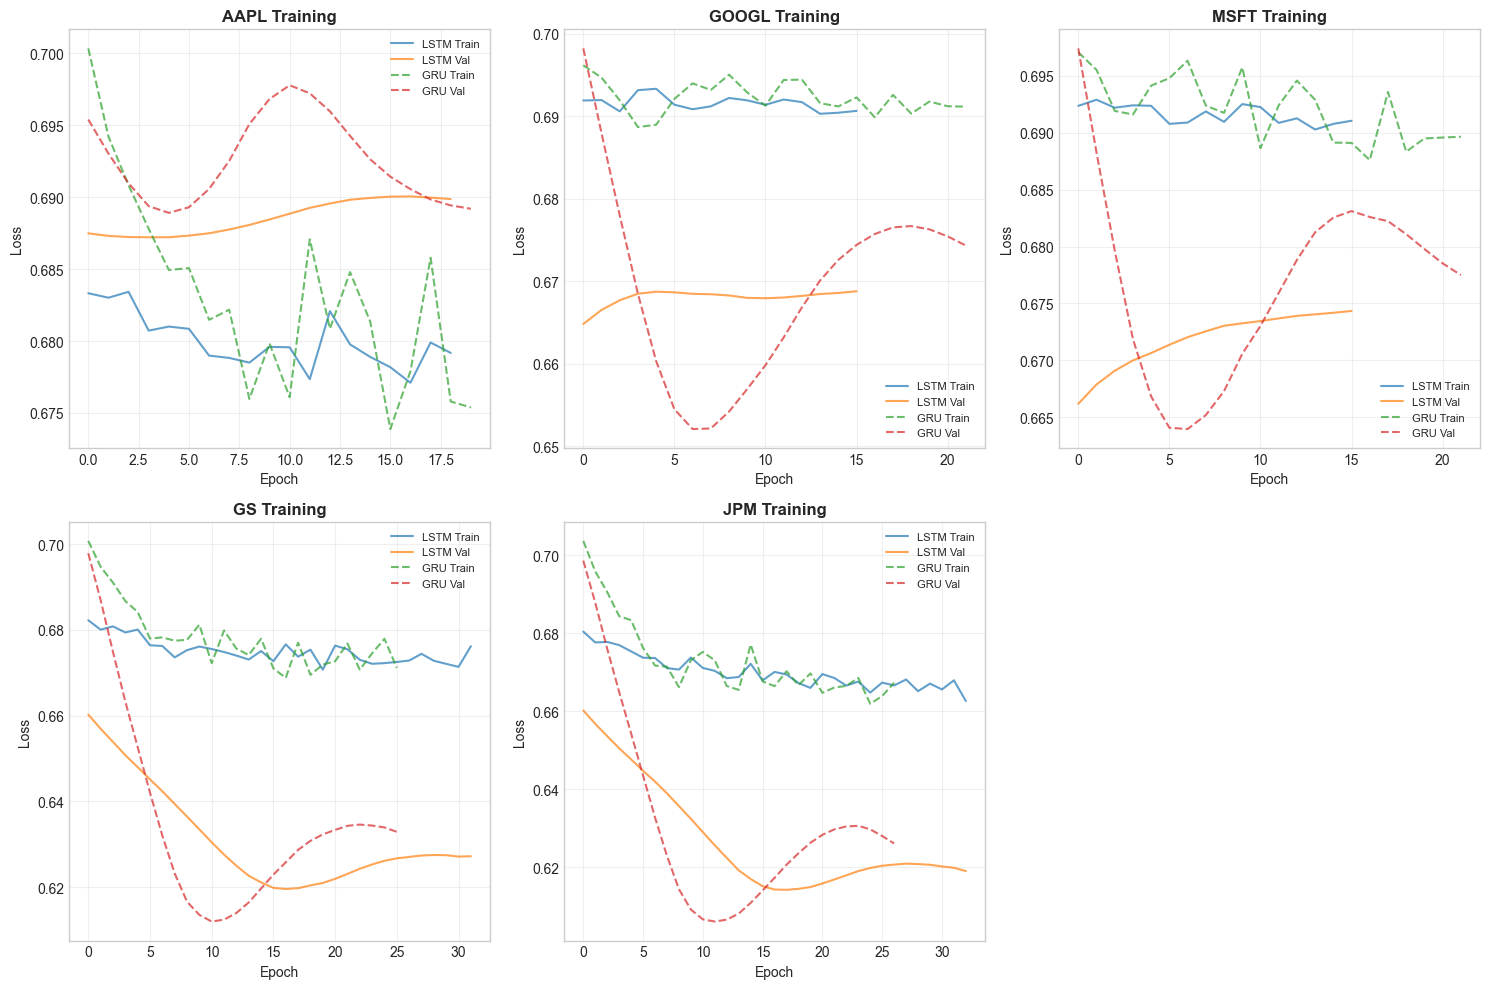

In [7]:
# ============================================================
# TRAINING VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    if ticker not in results:
        continue
    ax = axes[i]
    ax.plot(results[ticker]['lstm_train_loss'], label='LSTM Train', alpha=0.7)
    ax.plot(results[ticker]['lstm_val_loss'], label='LSTM Val', alpha=0.7)
    ax.plot(results[ticker]['gru_train_loss'], label='GRU Train', alpha=0.7, linestyle='--')
    ax.plot(results[ticker]['gru_val_loss'], label='GRU Val', alpha=0.7, linestyle='--')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{ticker} Training', fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

---

## 📊 Section 3: Model Comparison & Trading Signals

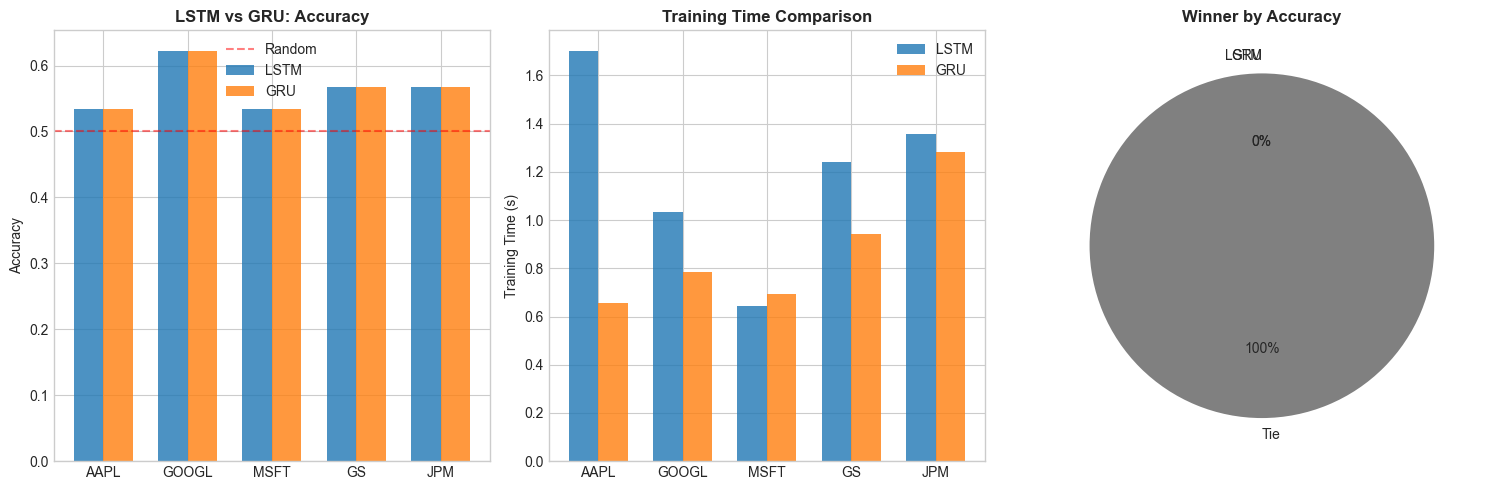

In [8]:
# ============================================================
# MODEL COMPARISON
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy comparison
ax1 = axes[0]
x = np.arange(len(TICKERS))
width = 0.35
lstm_accs = [results[t]['lstm_acc'] if t in results else 0 for t in TICKERS]
gru_accs = [results[t]['gru_acc'] if t in results else 0 for t in TICKERS]
ax1.bar(x - width/2, lstm_accs, width, label='LSTM', alpha=0.8)
ax1.bar(x + width/2, gru_accs, width, label='GRU', alpha=0.8)
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random')
ax1.set_xticks(x)
ax1.set_xticklabels(TICKERS)
ax1.set_ylabel('Accuracy')
ax1.set_title('LSTM vs GRU: Accuracy', fontweight='bold')
ax1.legend()

# Training time comparison
ax2 = axes[1]
lstm_times = [results[t]['lstm_time'] if t in results else 0 for t in TICKERS]
gru_times = [results[t]['gru_time'] if t in results else 0 for t in TICKERS]
ax2.bar(x - width/2, lstm_times, width, label='LSTM', alpha=0.8)
ax2.bar(x + width/2, gru_times, width, label='GRU', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(TICKERS)
ax2.set_ylabel('Training Time (s)')
ax2.set_title('Training Time Comparison', fontweight='bold')
ax2.legend()

# Winner summary
ax3 = axes[2]
lstm_wins = sum(1 for t in TICKERS if t in results and results[t]['lstm_acc'] > results[t]['gru_acc'])
gru_wins = sum(1 for t in TICKERS if t in results and results[t]['gru_acc'] > results[t]['lstm_acc'])
ties = len([t for t in TICKERS if t in results]) - lstm_wins - gru_wins
ax3.pie([lstm_wins, gru_wins, ties], labels=['LSTM', 'GRU', 'Tie'], 
        autopct='%1.0f%%', colors=['steelblue', 'orange', 'gray'], startangle=90)
ax3.set_title('Winner by Accuracy', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# GENERATE TRADING SIGNALS
# ============================================================

def get_sequence_signal(ticker, results, all_data):
    """Get trading signal from best performing model."""
    if ticker not in results or ticker not in all_data:
        return {'signal': 'N/A', 'confidence': 0}
    
    res = results[ticker]
    data = all_data[ticker]
    
    # Use best model
    best_model = res['lstm'] if res['lstm_acc'] >= res['gru_acc'] else res['gru']
    model_name = 'LSTM' if res['lstm_acc'] >= res['gru_acc'] else 'GRU'
    
    # Get latest sequence
    X_latest = torch.FloatTensor(data['X'][-1:])
    
    best_model.eval()
    with torch.no_grad():
        prob = best_model(X_latest).item()
    
    signal = 'BUY' if prob > 0.55 else ('SELL' if prob < 0.45 else 'HOLD')
    confidence = abs(prob - 0.5) * 2  # Convert to 0-1 scale
    
    return {
        'signal': signal,
        'probability': prob,
        'confidence': confidence,
        'model': model_name,
        'model_acc': res['lstm_acc'] if model_name == 'LSTM' else res['gru_acc']
    }

print("📊 SEQUENCE MODEL TRADING SIGNALS")
print("=" * 80)
print(f"\n{'Ticker':<10} {'Model':>8} {'Signal':>10} {'P(Up)':>10} {'Confidence':>12} {'Model Acc':>12}")
print("-" * 80)

current_signals = {}
for ticker in TICKERS:
    signal_info = get_sequence_signal(ticker, results, all_data)
    current_signals[ticker] = signal_info
    
    if signal_info['signal'] != 'N/A':
        emoji = "📈" if signal_info['signal'] == 'BUY' else ("📉" if signal_info['signal'] == 'SELL' else "⚪")
        print(f"{ticker:<10} {signal_info['model']:>8} {emoji} {signal_info['signal']:>6} {signal_info['probability']:>9.1%} {signal_info['confidence']:>11.1%} {signal_info['model_acc']:>11.1%}")

📊 SEQUENCE MODEL TRADING SIGNALS

Ticker        Model     Signal      P(Up)   Confidence    Model Acc
--------------------------------------------------------------------------------
AAPL           LSTM 📈    BUY     58.8%       17.5%       53.3%
GOOGL          LSTM ⚪   HOLD     52.8%        5.6%       62.2%
MSFT           LSTM ⚪   HOLD     52.5%        4.9%       53.3%
GS             LSTM 📈    BUY     59.1%       18.3%       56.7%
JPM            LSTM 📈    BUY     61.2%       22.4%       56.7%


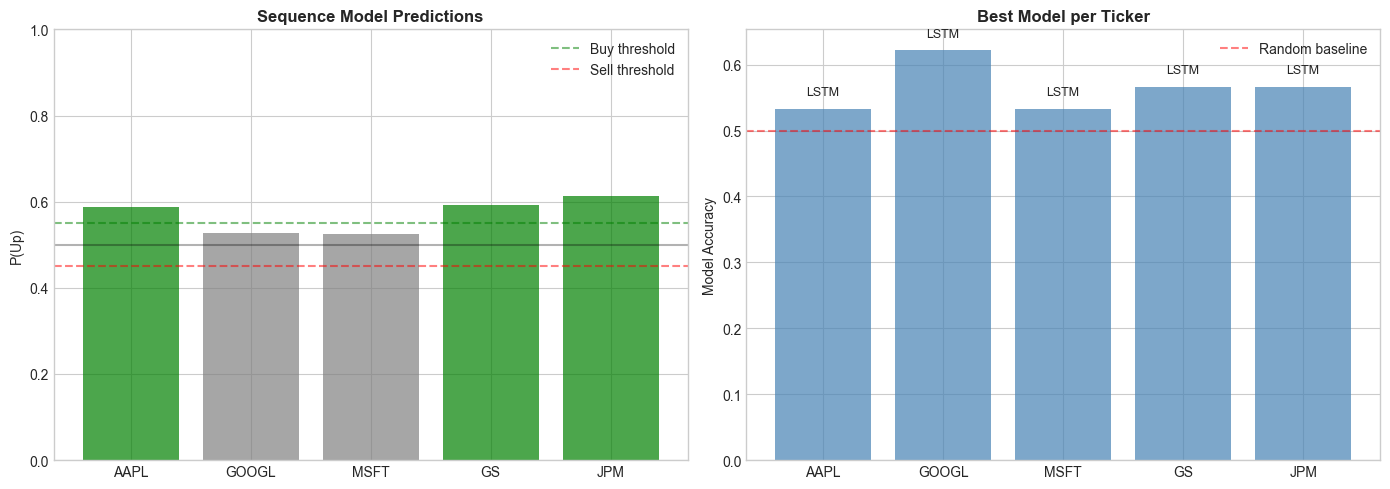

In [10]:
# ============================================================
# SIGNAL VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Signal probabilities
ax1 = axes[0]
probs = [current_signals[t].get('probability', 0.5) for t in TICKERS]
colors = ['green' if p > 0.55 else ('red' if p < 0.45 else 'gray') for p in probs]
ax1.bar(TICKERS, probs, color=colors, alpha=0.7)
ax1.axhline(y=0.5, color='k', linestyle='-', alpha=0.3)
ax1.axhline(y=0.55, color='g', linestyle='--', alpha=0.5, label='Buy threshold')
ax1.axhline(y=0.45, color='r', linestyle='--', alpha=0.5, label='Sell threshold')
ax1.set_ylabel('P(Up)')
ax1.set_title('Sequence Model Predictions', fontweight='bold')
ax1.legend()
ax1.set_ylim(0, 1)

# Model performance
ax2 = axes[1]
models = [current_signals[t].get('model', 'N/A') for t in TICKERS]
accs = [current_signals[t].get('model_acc', 0) for t in TICKERS]
colors = ['steelblue' if m == 'LSTM' else 'orange' for m in models]
bars = ax2.bar(TICKERS, accs, color=colors, alpha=0.7)
ax2.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random baseline')
ax2.set_ylabel('Model Accuracy')
ax2.set_title('Best Model per Ticker', fontweight='bold')
for i, (t, m) in enumerate(zip(TICKERS, models)):
    ax2.text(i, accs[i] + 0.02, m, ha='center', fontsize=9)
ax2.legend()

plt.tight_layout()
plt.show()

In [11]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 14 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary table
summary = pd.DataFrame({
    'LSTM Acc': [results[t]['lstm_acc'] if t in results else 0 for t in TICKERS],
    'GRU Acc': [results[t]['gru_acc'] if t in results else 0 for t in TICKERS],
    'Best Model': [current_signals[t].get('model', 'N/A') for t in TICKERS],
    'Signal': [current_signals[t]['signal'] for t in TICKERS],
    'P(Up)': [current_signals[t].get('probability', 0) for t in TICKERS]
}, index=TICKERS)

print("\n📋 MODEL & SIGNAL SUMMARY:")
print(summary.round(3).to_string())

# Recommendations
buys = [t for t in TICKERS if current_signals[t]['signal'] == 'BUY']
sells = [t for t in TICKERS if current_signals[t]['signal'] == 'SELL']
holds = [t for t in TICKERS if current_signals[t]['signal'] == 'HOLD']

print("\n🏆 SEQUENCE MODEL RECOMMENDATIONS:")
print(f"\n📈 BUY: {buys if buys else 'None'}")
print(f"📉 SELL: {sells if sells else 'None'}")
print(f"⚪ HOLD: {holds if holds else 'None'}")

# Model insights
avg_lstm = np.mean([results[t]['lstm_acc'] for t in TICKERS if t in results])
avg_gru = np.mean([results[t]['gru_acc'] for t in TICKERS if t in results])
print(f"\n📊 AVERAGE ACCURACY:")
print(f"   LSTM: {avg_lstm:.1%}")
print(f"   GRU:  {avg_gru:.1%}")

# Training efficiency
avg_lstm_time = np.mean([results[t]['lstm_time'] for t in TICKERS if t in results])
avg_gru_time = np.mean([results[t]['gru_time'] for t in TICKERS if t in results])
print(f"\n⏱️ AVERAGE TRAINING TIME:")
print(f"   LSTM: {avg_lstm_time:.2f}s")
print(f"   GRU:  {avg_gru_time:.2f}s (faster)")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 14 STRATEGY - FINAL RECOMMENDATIONS

📋 MODEL & SIGNAL SUMMARY:
       LSTM Acc  GRU Acc Best Model Signal  P(Up)
AAPL      0.533    0.533       LSTM    BUY  0.588
GOOGL     0.622    0.622       LSTM   HOLD  0.528
MSFT      0.533    0.533       LSTM   HOLD  0.525
GS        0.567    0.567       LSTM    BUY  0.591
JPM       0.567    0.567       LSTM    BUY  0.612

🏆 SEQUENCE MODEL RECOMMENDATIONS:

📈 BUY: ['AAPL', 'GS', 'JPM']
📉 SELL: None
⚪ HOLD: ['GOOGL', 'MSFT']

📊 AVERAGE ACCURACY:
   LSTM: 56.4%
   GRU:  56.4%

⏱️ AVERAGE TRAINING TIME:
   LSTM: 1.20s
   GRU:  0.87s (faster)

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-14)

| Week | Concept | Application |
|------|---------|-------------|
| 1-12 | Foundation to Advanced ML | Feature engineering |
| 13 | Neural Networks (MLP) | Baseline comparison |
| **14** | **LSTM** | **Long-term dependencies** |
| **14** | **GRU** | **Faster sequence modeling** |
| **14** | **Sliding Windows** | **Sequence creation** |
| **14** | **Binary Classification** | **Up/down prediction** |

---